In [29]:
import plotly.express as px
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

import DataRetriever as dr

retriever = dr.DataRetriever()
hour = retriever.get_data("All-Subsystems-hour-Year2.pkl")

producing = retriever.get_attributes("producing_attributes.pkl")
consuming = retriever.get_attributes("consuming_attributes.pkl")

pd.options.mode.chained_assignment = None

In [30]:
"""
LABELS:
    - Consuming as bool
    - Day of Week
    - hour of Day
"""

'\nLABELS:\n    - Consuming as bool\n    - Day of Week\n    - hour of Day\n'

In [31]:
#temp = hour.loc[:, ~hour.columns.isin(producing)]
X =  hour[consuming].copy() # hour.groupby(pd.Grouper(key="Timestamp", axis=0, freq='D')).sum()[consuming]
X.fillna(0, inplace=True)

# X.drop_duplicates(inplace=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X)

n_components = 2
tsne = TSNE(n_components, random_state=0, init="pca", learning_rate="auto")
tsne_result = tsne.fit_transform(X)
tsne_result = pd.DataFrame(tsne_result)
tsne_result

/Users/heede/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



0          1
0     35.584396  40.835300
1     34.777279  40.944412
2     35.321831  40.985809
3     35.912098  41.235294
4     35.376694  41.006451
...         ...        ...
8755 -69.702156  53.271072
8756 -50.348579  24.382154
8757 -62.909027  23.511284
8758 -15.385092  15.034280
8759  24.756277  21.403252

[8760 rows x 2 columns]

In [32]:
tsne_result["DoW"] = (hour["Timestamp"].dt.day_name()).reset_index(drop=True)

In [33]:
tsne_result["hour"] = (hour["Timestamp"].dt.hour).reset_index(drop=True)

In [34]:
tsne_result["ClothesWasher"] = np.where(hour["Load_ClothesWasherPowerWithStandby"] > 20, "On", "Off")
tsne_result["Oven"] = np.where(hour["Load_OvenPowerTotal"] > 20, "On", "Off")

In [35]:
tsne_result["DishWasher"] = np.where(hour["Elec_PowerDishwasher"] > 20, "On", "Off")
tsne_result["Microwave"] = np.where(hour["Load_MicrowavePowerWithStandby"] > 20, "On", "Off")
tsne_result["Dryer"] = np.where(hour["Load_DryerPowerTotal"] > 20, "On", "Off")

In [36]:
tsne_result

0          1     DoW  hour ClothesWasher Oven DishWasher  \
0     35.584396  40.835300  Sunday     0           Off  Off        Off   
1     34.777279  40.944412  Sunday     1           Off  Off        Off   
2     35.321831  40.985809  Sunday     2           Off  Off        Off   
3     35.912098  41.235294  Sunday     3           Off  Off        Off   
4     35.376694  41.006451  Sunday     4           Off  Off        Off   
...         ...        ...     ...   ...           ...  ...        ...   
8755 -69.702156  53.271072  Sunday    19           Off  Off        Off   
8756 -50.348579  24.382154  Sunday    20           Off  Off        Off   
8757 -62.909027  23.511284  Sunday    21           Off  Off         On   
8758 -15.385092  15.034280  Sunday    22           Off  Off        Off   
8759  24.756277  21.403252  Sunday    23           Off  Off        Off   

     Microwave Dryer  
0          Off   Off  
1          Off   Off  
2          Off   Off  
3          Off   Off  
4          Off   Off  
...        ...   ...  
8755       Off   Off  
8756       Off   Off  
8757       Off   Off  
8758       Off   Off  
8759       Off   Off  

[8760 rows x 9 columns]

In [37]:
fig = px.scatter(x=tsne_result.iloc[:, 0], y=tsne_result.iloc[:, 1])
fig.show()

In [38]:
for col in ["DoW", "hour", "ClothesWasher", "Oven", "DishWasher", "Microwave", "Dryer"]:
    fig = px.scatter(x=tsne_result.iloc[:, 0],
                             y=tsne_result.iloc[:, 1],
                             color=tsne_result[col],
                             opacity=1,
                             labels={"color": col})
    fig.show()

# DBSCAN

In [39]:
from sklearn.cluster import DBSCAN

In [40]:
tsne_result.rename(columns={0: "X1", 1:"X2"}, inplace=True)
X_tsne = tsne_result[["X1", "X2"]]

In [41]:
tsne_result

X1         X2     DoW  hour ClothesWasher Oven DishWasher  \
0     35.584396  40.835300  Sunday     0           Off  Off        Off   
1     34.777279  40.944412  Sunday     1           Off  Off        Off   
2     35.321831  40.985809  Sunday     2           Off  Off        Off   
3     35.912098  41.235294  Sunday     3           Off  Off        Off   
4     35.376694  41.006451  Sunday     4           Off  Off        Off   
...         ...        ...     ...   ...           ...  ...        ...   
8755 -69.702156  53.271072  Sunday    19           Off  Off        Off   
8756 -50.348579  24.382154  Sunday    20           Off  Off        Off   
8757 -62.909027  23.511284  Sunday    21           Off  Off         On   
8758 -15.385092  15.034280  Sunday    22           Off  Off        Off   
8759  24.756277  21.403252  Sunday    23           Off  Off        Off   

     Microwave Dryer  
0          Off   Off  
1          Off   Off  
2          Off   Off  
3          Off   Off  
4          Off   Off  
...        ...   ...  
8755       Off   Off  
8756       Off   Off  
8757       Off   Off  
8758       Off   Off  
8759       Off   Off  

[8760 rows x 9 columns]

In [42]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=12)
neighbors = nearest_neighbors.fit(X_tsne)

distances, indices = neighbors.kneighbors(X_tsne)
distances = np.sort(distances[:,10], axis=0)

fig = px.scatter(distances)
fig.show()

In [43]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
print(distances[knee.knee])

2.2039325108509953


In [44]:
dbscan_cluster = DBSCAN(eps=distances[knee.knee]*1.85, min_samples=10)
dbscan_cluster.fit(X_tsne)

labels=dbscan_cluster.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

X_tsne["Group"] = dbscan_cluster.labels_

fig = px.scatter(x=X_tsne.iloc[:, 0], y=X_tsne.iloc[:, 1], color=X_tsne["Group"], opacity=1, labels={"color": "Group"})
fig.show()

Estimated no. of clusters: 55
Estimated no. of noise points: 33


# RF / DT

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt
from sklearn.tree import export_text
from sklearn import tree

In [75]:
rf_df = hour[consuming].reset_index(drop=True)

In [76]:
ohe = OneHotEncoder(sparse=False)
hot_np = ohe.fit_transform(tsne_result[["DoW", "hour"]])
hot = pd.DataFrame(data=hot_np, columns=ohe.get_feature_names_out())
hot

DoW_Friday  DoW_Monday  DoW_Saturday  DoW_Sunday  DoW_Thursday  \
0            0.0         0.0           0.0         1.0           0.0   
1            0.0         0.0           0.0         1.0           0.0   
2            0.0         0.0           0.0         1.0           0.0   
3            0.0         0.0           0.0         1.0           0.0   
4            0.0         0.0           0.0         1.0           0.0   
...          ...         ...           ...         ...           ...   
8755         0.0         0.0           0.0         1.0           0.0   
8756         0.0         0.0           0.0         1.0           0.0   
8757         0.0         0.0           0.0         1.0           0.0   
8758         0.0         0.0           0.0         1.0           0.0   
8759         0.0         0.0           0.0         1.0           0.0   

      DoW_Tuesday  DoW_Wednesday  hour_0  hour_1  hour_2  ...  hour_14  \
0             0.0            0.0     1.0     0.0     0.0  ...      0.0   
1             0.0            0.0     0.0     1.0     0.0  ...      0.0   
2             0.0            0.0     0.0     0.0     1.0  ...      0.0   
3             0.0            0.0     0.0     0.0     0.0  ...      0.0   
4             0.0            0.0     0.0     0.0     0.0  ...      0.0   
...           ...            ...     ...     ...     ...  ...      ...   
8755          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8756          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8757          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8758          0.0            0.0     0.0     0.0     0.0  ...      0.0   
8759          0.0            0.0     0.0     0.0     0.0  ...      0.0   

      hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
8755      0.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   
8756      0.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0   
8757      0.0      0.0      0.0      0.0      0.0      0.0      1.0      0.0   
8758      0.0      0.0      0.0      0.0      0.0      0.0      0.0      1.0   
8759      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      hour_23  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
8755      0.0  
8756      0.0  
8757      0.0  
8758      0.0  
8759      1.0  

[8760 rows x 31 columns]

In [77]:
rf_df = rf_df.merge(hot, left_index=True, right_index=True)
rf_df["Target"] = dbscan_cluster.labels_

rf_df.dropna(inplace=True)
target = 2
rf_df["Target"][rf_df["Target"] != target] = rf_df["Target"][rf_df["Target"] != target] = -1
rf_df["Target"]

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
8755   -1
8756   -1
8757   -1
8758   -1
8759   -1
Name: Target, Length: 8671, dtype: int64

In [78]:
X_rf = rf_df[consuming + hot.columns.tolist()]
y_rf = rf_df["Target"]

In [79]:
clf = DecisionTreeClassifier()#max_leaf_nodes=55, random_state=0, max_depth=6)
clf.fit(X_rf, y_rf)

feature_names = list(X_rf.columns)
r = export_text(clf, feature_names=feature_names)
print(r)

|--- Load_KPlugLoadsPowerUsage <= 403.52
|   |--- Load_OvenPowerTotal <= 474.50
|   |   |--- class: -1
|   |--- Load_OvenPowerTotal >  474.50
|   |   |--- Load_KPlugLoadsPowerUsage <= 233.52
|   |   |   |--- class: -1
|   |   |--- Load_KPlugLoadsPowerUsage >  233.52
|   |   |   |--- Elec_PowerLightsBasementStair <= 11.57
|   |   |   |   |--- class: 2
|   |   |   |--- Elec_PowerLightsBasementStair >  11.57
|   |   |   |   |--- class: -1
|--- Load_KPlugLoadsPowerUsage >  403.52
|   |--- Elec_PowerLightsBasementStair <= 11.53
|   |   |--- class: 2
|   |--- Elec_PowerLightsBasementStair >  11.53
|   |   |--- class: -1



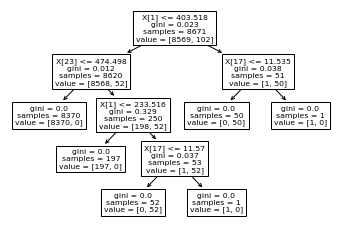

In [80]:
tree.plot_tree(clf)
plt.show()

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(clf.predict(X_rf),y_rf)

1.0